In [38]:
# Importing all the necessary Libraries
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [39]:
# Directory path
train_dir = './COMP90086_2021_Project_train'
test_dir = './COMP90086_2021_Project_test'
train_img_dir = train_dir + '/train/'
test_img_dir = test_dir + '/test/'

In [40]:
def extract_zip_files(dir):
    """
    Extracting all the files from the given folder path
    """
    with zipfile.ZipFile(dir + '.zip', "r") as zip_ref:
        zip_ref.extractall(dir)

In [41]:
# Unzipping train and test folders
extract_zip_files(train_dir)
extract_zip_files(test_dir)

In [42]:
labels = {}
label_to_coordinate = {}

In [43]:
def append_ext(filename):
    """
    Appending image name with .jpg
    """
    return filename + ".jpg"

def create_label(x, y):
    """
    Label Encoding the coordinates
    """
    if (x, y) not in labels:
        if 0 == len(labels.keys()):
            labels[(x, y)] = 0
            label_to_coordinate[0]=(x, y)
        else:
            label = labels[list(labels.keys())[-1]] + 1
            labels[(x, y)] = label
            label_to_coordinate[label]=(x, y)
            
    return labels[(x, y)]

In [44]:
# Reading csv files to read image names and their coordinates
df_train = pd.read_csv(os.path.join(train_dir, 'train.csv'))
df_test = pd.read_csv(os.path.join(test_dir, 'imagenames.csv'))

# Appending extensions to the image name
df_train["id"] = df_train["id"].apply(append_ext)
df_test["id"] = df_test["id"].apply(append_ext)

# Label encoding the coordinates
df_train["label"] = df_train.apply(lambda key: create_label(key.x, key.y), axis=1)

df_train.head()

,id,x,y,label
0,IMG2744_1.jpg,-9.380678,3.58272,0
1,IMG2744_2.jpg,-9.380678,3.58272,0
2,IMG2744_3.jpg,-9.380678,3.58272,0
3,IMG2744_4.jpg,-9.380678,3.58272,0
4,IMG2744_5.jpg,-9.380678,3.58272,0


In [45]:
# Stratified splitting by label encoded coordinates with 80:20 ratio
train_df, validation_df = train_test_split(df_train, random_state=24, test_size=0.2, stratify=df_train['label'])

In [46]:
len(train_df), len(validation_df)

(6000, 1500)

In [47]:
# Sort ID's so that same location pics are next to each other
# This is done in case if the order is changed
train_df = train_df.sort_values("id")

In [48]:
# Horizontally concatenating the training images 
train_length = train_df.shape[0]
train_imgs = []
train_labels = []

img_name = ""
concatenated_img = []

for i in tqdm(train_df.index):
    splitted_img_name = df_train['id'][i].split('_')[0]
    img_path = train_img_dir + df_train['id'][i]
    img = cv2.imread(img_path, 0)

    if img_name == splitted_img_name:
        concatenated_img = cv2.hconcat([concatenated_img, img])
    else:
        if len(concatenated_img):
            train_imgs.append(concatenated_img)
            
        img_name = splitted_img_name
        concatenated_img = img
        train_labels.append(df_train['label'][i])   
        
train_imgs.append(concatenated_img)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:39<00:00, 150.95it/s]


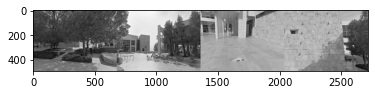

In [49]:
# Displaying first concatenated images
plt.imshow(train_imgs[0], cmap="gray")

In [50]:
def calc_features(img):
    """
    3000 best features are retained for the images
    """
    sift = cv2.SIFT_create(3000)
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

In [51]:
y_train = []
train_kp_and_des = []

# Storing all the best 3000 features of training images with its lables
for i in tqdm(range(len(train_imgs))):
    img_kp, img_des = calc_features(train_imgs[i])
    
    if img_des is not None:
        train_kp_and_des.append((img_kp, img_des))
        y_train.append(train_labels[i])

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [07:30<00:00,  3.33it/s]


In [ ]:
result = []
manhattan_dist = 0

# Manhattan error is calculated for validation datset
# Note: The following code is inspired from Workshop Week 7 Solution
for i in tqdm(validation_df.index[:2]):
    crct_coor = df_train['label'][i]
    val_img_path = train_img_dir + df_train['id'][i]
    val_img = cv2.imread(val_img_path, 0)
    
    # Calculating validation image features
    val_img_kp, val_img_des = calc_features(val_img)
    
    y_val = -1
    max_matches = 0
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=10)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Comparing validation image features with all the training images
    for details, label in zip(train_kp_and_des, y_train):
        # Matching descriptor using KNN algorithm
        matches = flann.knnMatch(val_img_des, details[1], k=2)
        
        # Store all good matches as per Lowe's Ratio test.
        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)
           
                
        if len(good_matches) > 3: # Considering min 3 matching features
            # If enough matches are found, we extract the positions of the matched keypoints in both images. 
    
            train_img_pts = np.float32([details[0][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            test_img_pts = np.float32([val_img_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            
            h, status = cv2.findHomography(test_img_pts, train_img_pts, 
                                           cv2.RANSAC,
                                           ransacReprojThreshold=5, 
                                           maxIters=20
                                          )
            
            matchesMask = status.ravel().tolist()
            
            # Check whether this training image has more matching feature
            # If yes, note this training image label
            if matchesMask.count(1) and max_matches < matchesMask.count(1):
                max_matches = matchesMask.count(1)
                y_val = label
    
    # Storing Image name with their true coordinates
    data = {
        "id": df_train['id'][i].split(".")[0],
        "true_x": label_to_coordinate[crct_coor][0],
        "true_y": label_to_coordinate[crct_coor][1]
    }
    
    if y_val == -1:
        # In case, the minimum number of matches are found, we are going with (0, 0) as prediction
        data['x'] = 0
        data['y'] = 0  
    else:
        # Decoding the labels to coordinates and storing it
        data['x'] = label_to_coordinate[y_val][0]
        data['y'] = label_to_coordinate[y_val][1]
    
    # Calculating absolute error
    err = abs(data['true_x'] - data['x']) - abs(data['true_y'] - data['y'])
    manhattan_dist += err  
    data['manhattan_err'] = manhattan_dist
    
    result.append(data)
    
print("Absolute mean error for the validation set is {}".format(manhattan_dist/len(validation_df)))

In [53]:
# Here, we are using the whole dataset for predicting the test images.
# Horizontally Concatenating the different views of same location of whole dataset
train_length = df_train.shape[0]
train_imgs = []
train_labels = []

img_name = ""
concatenated_img = []

for i in tqdm(range(train_length)):
    splitted_img_name = df_train['id'][i].split('_')[0]
    img_path = train_img_dir + df_train['id'][i]
    img = cv2.imread(img_path, 0)

    if img_name == splitted_img_name:
        concatenated_img = cv2.hconcat([concatenated_img, img])
    else:
        if len(concatenated_img):
            train_imgs.append(concatenated_img)
            
        img_name = splitted_img_name
        concatenated_img = img
        train_labels.append(df_train['label'][i])   
        
train_imgs.append(concatenated_img)

100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:13<00:00, 570.12it/s]


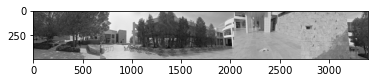

In [54]:
# Displaying the horizontally ocncantenated image
plt.imshow(train_imgs[0], cmap="gray")

In [55]:
# Storing all the best 3000 features of training images with its lables
y_train = []
train_kp_and_des = []

for i in tqdm(range(len(train_imgs))):
    img_kp, img_des = calc_features(train_imgs[i])
    
    if img_des is not None:
        train_kp_and_des.append((img_kp, img_des))
        y_train.append(train_labels[i])

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [09:16<00:00,  2.70it/s]


In [ ]:
test_result = []

# Note: The following code is inspired from Workshop Week 7 Solution
for i in tqdm(range(0, len(df_test[:2]))):
    test_img_path = test_img_dir + df_test['id'][i]
    test_img = cv2.imread(test_img_path, 0)
    test_img_kp, test_img_des = calc_features(test_img)
    y_test = -1
    max_matches = 0
    
    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=10)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    for details, label in zip(train_kp_and_des, y_train):
        # Matching descriptor using KNN algorithm
        matches = flann.knnMatch(test_img_des, details[1], k=2)
        
        good_matches = []
        # Store all good matches as per Lowe's Ratio test.
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)
           
                
        if len(good_matches) > 3: # Considering min 3 matching features
             # If enough matches are found, we extract the positions of the matched keypoints in both images. 
            train_img_pts = np.float32([details[0][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            test_img_pts = np.float32([test_img_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            
            h, status = cv2.findHomography(test_img_pts, train_img_pts, 
                                           cv2.RANSAC,
                                           ransacReprojThreshold=5, 
                                           maxIters=20
                                          )
            
            matchesMask = status.ravel().tolist()
            
            # Check whether this training image has more matching feature
            # If yes, note this training image label
            if matchesMask.count(1) and max_matches < matchesMask.count(1):
                max_matches = matchesMask.count(1)
                y_test = label
                
    if y_val == -1:
        # In case, the minimum number of matches are found, we are going with (0, 0) as prediction
        data['x'] = 0
        data['y'] = 0  
    else:
        # Decoding the labels to coordinates and storing it
        data['x'] = label_to_coordinate[y_val][0]
        data['y'] = label_to_coordinate[y_val][1]
    
    test_result.append(data)

In [57]:
# Converting the result into dataframe
df_prediction = pd.DataFrame(test_result, columns = ['id', 'x', 'y'])

In [58]:
df_prediction.to_csv("./sift_predictions.csv", index=False)